Linear Regression Data Exploration: Lending Club
=========
***

### How can I predict interest rates based on borrower and loan attributes?

The [Lending Club](http://www.lendingclub.com) is a peer-to-peer lending site where members make loans to each other.
The site makes anonymized data on loans and borrowers publicly available.  We're going to use these data to explore how the interest rate charged on loans depends on various factors.

We want to explore these data, try to gain some insights into what might be useful in creating a linear regression model, and to separate out "the noise".

We follow these steps, something we will do in future for other data sets as well.

1. Browse the data  
2. Data cleanup  
3. Visual exploration  
4. Model derivation  


## I. Browse Data
		 	 	
The data have the following variables (with data type and explanation of meaning)
			
* __Amount.Requested__ - _numeric_. The amount (in dollars) requested in the loan application.  		
  
* __Amount.Funded.By.Investors__ - _numeric_.  The amount (in dollars) loaned to the individual.  

* Interest.rate – character. The lending interest rate charged to the borrower.  

* Loan.length - character. The length of time (in months) of the loan.    			

* Loan.Purpose – categorical variable. The purpose of the loan as stated by the applicant.   

* Debt.to.Income.Ratio – character  The % of consumer’s gross income going toward paying debts.   

* State - character. The abbreviation for the U.S. state of residence of the loan applicant.   

* Home.ownership - character. Indicates whether the applicant owns, rents, or has a mortgage.   

* Monthly.income -­ categorical. The monthly income of the applicant (in dollars).  

* FICO.range  – categorical (expressed as a string label e.g. “650-655”). A range indicating the applicants FICO score. 	

* Open.CREDIT.Lines - numeric. The number of open lines of credit at the time of application.  

* Revolving.CREDIT.Balance - numeric. The total amount outstanding all lines of credit.   			

* Inquiries.in.the.Last.6.Months - numeric. Number of credit inquiries in the previous 6 months.  

* Employment.Length - character.  Length of time employed at current job.  
		

## II. Data Cleanup 

We find the data are "messy" i.e aren't cleanly prepared for import - for instance numeric columns might have some strings in them.  This is very common in raw data especially that obtained from web sites.

Let's take a look. we're going to look at the first five rows of some specific columns that show the data dirtiness issues.

In [1]:
%matplotlib inline
# first we ingest the data from the source on the web
# this contains a reduced version of the data set from Lending Club

import pandas as pd
loansData = pd.read_csv('https://spark-public.s3.amazonaws.com/dataanalysis/loansData.csv')

In [2]:
loansData['Interest.Rate'][0:5] # first five rows of Interest.Rate

81174     8.90%
99592    12.12%
80059    21.98%
15825     9.99%
33182    11.71%
Name: Interest.Rate, dtype: object

In [3]:
loansData['Loan.Length'][0:5] # first five rows of Loan.Length

81174    36 months
99592    36 months
80059    60 months
15825    36 months
33182    36 months
Name: Loan.Length, dtype: object

We see here that:

* the interest rate information has "%" symbols in it.
* loan length has " months" in it

Other than that we can also see (exploration exercise):

* there are a couple of values that are so large they must be typos
* some values are missing "NA" values i.e. not available.
* the FICO Range is really a numeric entity but is represented as a categorical variable in the data.

In [4]:
loansData['FICO.Range'][0:5] # first five rows of FICO.Range

81174    735-739
99592    715-719
80059    690-694
15825    695-699
33182    695-699
Name: FICO.Range, dtype: object

FICO Range is represented as a categorical variable in the data.

We need to change the categorical variable for FICO Range into something numeric so that we can use it in our calculations.  As it stands, the values are merely labels, and while they convey meaning to humans, our software can't interpret them as the numbers they really represent.

So as a first step, we convert them from categorical variables to strings.  So the abstract entity 735-739 becomes a string "735-739".
Then we parse the strings so that a range such as "735-739" gets split into two numbers (735,739).

Finally we pick a single number to represent this range. We could choose a midpoint but since the ranges are narrow we can get away with choosing one of the endpoints as a representative. Here we arbitrarily pick the lower limit and with some imperious hand waving, assert that it is not going to make a major difference to the outcome.

In a further flourish of imperiousness we could declare that "the proof is left as an exercise to the reader". But in reality there is really no such formal "proof" other than trying it out in different ways and convincing oneself.  If we wanted to be mathematically conservative we could take the midpoint of the range as a representative and this would satisfy most pointy-haired mathematician bosses that "Data Science Dilbert" might encounter.


To summarize - cleaning our data involves:

* removing % signs from rates
* removing the word ” months" from loan length.
* managing outliers - remove such rows in this case
* managing NA - remove such rows in this case

There is one especially high outlier with monthly income > 100K$+.  
This is likely to be a typo and is removed as a data item.  
There is also one data item with all N/A - this is also removed.  

##Exercise
Actually perform each of the above steps on the dataset i.e.

* import the data
* remove the '%' suffix from each row
* remove the ' months' suffix from each row
* remove the outlier rows
* remove rows with NA

Save your code in a reusable manner - these are steps you'll be doing repeatedly.


##Visual Exploration  

Now we are going to follow a standard set of steps in exploring data.  We apply the following simple visualizations. This is something we will typically also do for other data sets we encounter in other explorations.  

###Histogram

A histogram shows us the shape of the distribution of values for a **single** variable.
On the x-axis we have the variable under question, divided into buckets or bins.  This is a key feature of a histogram.

The bin size is adjustable and different bin sizes give different information.  A large bin size gives us an idea of the coarser grained structure of the distribution while a smaller bin size will shine light on the finer details of the distribution.  In either case we can compare distributions, or quickly identify some key hints that tell use how best to proceed.

With the distribution of FICO scores we see the histogram below.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure()
loansmin = pd.read_csv('./datasets/loanf.csv')

loansmin.head()

,Interest.Rate,FICO.Score,Loan.Length,Monthly.Income,Loan.Amount
6,15.31,670,36,4891.67,6000
11,19.72,670,36,3575.00,2000
12,14.27,665,36,4250.00,10625
13,21.67,670,60,14166.67,28000
21,21.98,665,36,6666.67,22000


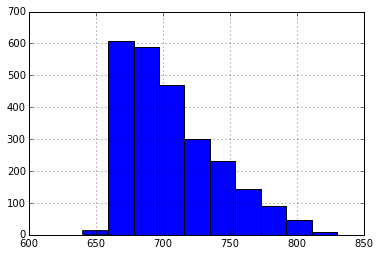

In [9]:
fico = loansmin['FICO.Score']
p = fico.hist(bins=10) 

  

Why do we look at FICO score?  Because we know from domain knowledge that this is the primary determinant of interest rate.  
The histogram shows us that the distribution is not a normal or gaussian distribution but that there are some other factors that might be affecting or distorting the shape of the distribution away from the bell curve.  We want to dig a little deeper.  

###Box Plot

Next we take a box plot which allows us to quickly look at the distribution of interest rates based on each FICO score range.   


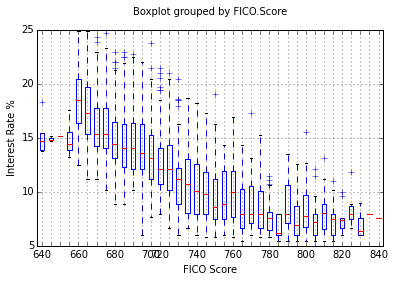

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure()
loansmin = pd.read_csv('./datasets/loanf.csv')

p = loansmin.boxplot('Interest.Rate','FICO.Score')
q = p.set_xticklabels(['640','','','','660','','','','680','','','','700',
  '720','','','','740','','','','760','','','','780','','','','800','','','','820','','','','840'])

q0 = p.set_xlabel('FICO Score')
q1 = p.set_ylabel('Interest Rate %')
q2 = p.set_title('                          ')


First of all this tells us that there is a general downward trend in interest rate for higher FICO scores.
But, given the same range of FICO scores we see a range of interest rates not a single value - so it appears there are other factors determining interest rate, given the same FICO score range. We want to investigate the impact of these other drivers and quantify this impact.  

What might these be?    

Let's use a little domain knowledge again. We know interest rate is based on risk to the borrower: the greater the risk, the greater the interest rate charged to compensate for the risk.  Another factor that might affect risk is the size of the loan - the larger the amount the greater the risk of non-payment and also the greater the negative impact of actual default.

We want to look at multiple factors and how they might affect the interest rate.  
A great way to look at multiple factors simultaneously is the scatterplot matrix.  We are going to use this as the next step in visual exploration.  

### Scatterplot Matrix

But first what is it?  

The scatterplot matrix is a grid of plots of multiple variables against each other.  It shows the relationship of each variable to the others.  The ones on the diagonal don't fit this pattern. Why not? What does it mean to find the relationship of something to itself, in this context.  Not much, since we are trying to determine the impact of some variable on **another** variable.  

We're going to look at a scatterplot matrix of the five variables in our data.

<img src="files/images/important.png" />

/Users/lr/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


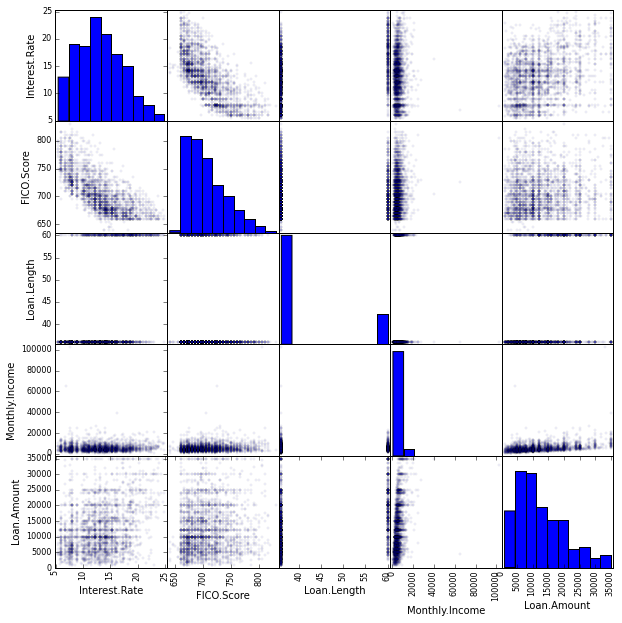

In [12]:
## TRY THIS!


a = pd.scatter_matrix(loansmin,alpha=0.05,figsize=(10,10), diagonal='hist')

## Click on the line above
## Change 'hist' to 'kde' then hit shift-enter, with the cursor still in this box
## The plot will redraw - it takes a while. While it is recomputing you will see a 
## message-box that says 'Kernel Busy' near the top right corner
## You can change the code and hit shift-enter to re-execute the code
## Try changing the (10,10) to (8,8) and (12,12)
## Try changing the alpha value from 0.05 to 0.5 
## How does this change in alpha change your ability to interpret the data?
## Feel free to try other variations. 
## If at any time you scramble the code and forget the syntax 
## a copy of the original code is below. Copy and paste it in place. 
## Remember to remove the hashmarks.
## a = pd.scatter_matrix(loansmin, alpha=0.05,figsize=(10,10), diagonal='hist)


In this diagram, the boxes on the diagonal contain histogram plots of the respective variable itself.

So if the 3rd variable is Loan Amount then the third row and third column are the Loan Amount column and row. And the third element down the diagonal is the histogram of the Loan Amount.  

To see how Loan Amount (3rd) affects Interest Rate (1st) then we look for the intersection of the 3rd row and the 1st column.  

We also notice that we could have looked for the intersection of the 3rd column and 1st row.  They have the same plot. The scatterplot matrix plot is visually symmetric about the diagonal.

Where there is some significant, useful effect we will see a noticeable trend in the scatterplot at the intersection.  Where there is none we will see no noticeable trend.  

What do the last two sentences mean in practice?

Let's compare two plots: the first one at the intersection of 1st row and 2nd column, and the second at the intersection of 1st row 4th column.

In the first, FICO score shows an approximate but unmistakeable linear trend.

In the second, Monthly Income shows no impact as we move along the x-axis. All the dots are bunched up near one end but show no clear, linear trend like the first one. 

Similarly there is no obvious variation in the plot for Loan Length while there is a distinct but increasing trend trend also in the plot for Loan Amount.

So what does this suggest?  It suggests that we should use FICO and Loan Amount in our model as independent variables, while Monthly Income and Loan Length don't seem to be too useful as independent variables.

## Conclusion
So at the end of this data alchemy exercise we have distilled our variables into two beakers - one has what we believe is relevant - the data nuggets, and the other, the data dross.....the variables that have no visible impact on our dependent variable.

We're going to refine our output even further into a model in the next step - the analysis.

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()